# Final project for Artificial Intelligence and Machine Learning Course at Univeristy of Chicago

Goal of our project is to predict future REIT performance through stock data, real estate data and news article sentiment analysis. For the scope of this analysis, we will focus on the office sector within REITs as a way of narrowing our scope. 

By Cameron Keith and Jonathan Ling (August 2023)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [48]:
# Read in Green Street data
df = pd.read_excel('Green Street REIT Data.xlsx')
print(df.shape)
df.head()

(29774, 227)


,date,comp_id,sector_id,sector_pm1_id,date_bom,date_bs,date_eom,date_last_published,date_mrpo,date_price,...,cg_wme_auto_exemption_points,cg_wme_veto_points,cg_wme_rights_points,cg_wme_rights_authority_points,cg_wme_rights_total_points,cg_wme_points,cg_other_materiality_points,cg_other_tax_basis_points,cg_other_points,cg_score
0,1988-10-24,6,NaN,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1988-10-24,7,1.0,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1988-10-24,16,NaN,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1988-10-24,30,11.0,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1988-10-24,31,NaN,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
# Convert to datetime
df['date'] = pd.to_datetime(df['date'], format='%b-%y').dt.to_period('M')
df['year'], df['month'] = df['date'].dt.year, df['date'].dt.month # our data is monthly frequency

In [93]:
df.head()

,date,comp_id,sector_id,sector_pm1_id,date_bom,date_bs,date_eom,date_last_published,date_mrpo,date_price,...,cg_wme_rights_points,cg_wme_rights_authority_points,cg_wme_rights_total_points,cg_wme_points,cg_other_materiality_points,cg_other_tax_basis_points,cg_other_points,cg_score,year,month
0,1988-10,6,NaN,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,10
1,1988-10,7,1.0,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,10
2,1988-10,16,NaN,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,10
3,1988-10,30,11.0,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,10
4,1988-10,31,NaN,NaN,1988-11-01,NaT,1988-10-01,NaT,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1988,10


In [94]:
# Let's drop descriptive features that won't help our model
drop_list = ['comp_id','sector_id','sector_pm1_id','date_bom','date_bs',
             'date_eom','date_last_published','date_mrpo','date_price','ticker_bb',
             'currency_symbol','sector_abbr','sector_pm1','sector_rt','initial1','initial2']

df_cleaned = df.copy()
df_cleaned = df_cleaned.drop(drop_list, axis=1)

In [95]:
# Since we have a very wide dataset, we are going to focus on some features that
# should impact the sector/performance (utilizing Jonathan's industry knowledge)

testing_vars = ['date','year','month','symbol','price','dividend_yield','cash','nav_premium',
                'noi','capex_reserve', 'caprate_nominal_implied']

df_testing = df_cleaned.loc[df_cleaned['sector'] == 'Office'] # focus on office sector
df_testing = df_testing[testing_vars]
df_testing.head()

,date,year,month,symbol,price,dividend_yield,cash,nav_premium,noi,capex_reserve,caprate_nominal_implied
1352,1993-01,1993,1,RCP,8.38,NaN,NaN,-0.301667,NaN,NaN,NaN
1370,1993-02,1993,2,CRE,24.25,NaN,NaN,0.154762,NaN,NaN,NaN
1388,1993-02,1993,2,RCP,9.50,NaN,NaN,-0.208333,NaN,NaN,NaN
1406,1993-03,1993,3,CRE,26.00,0.065,NaN,0.106383,NaN,NaN,NaN
1424,1993-03,1993,3,RCP,9.13,0.110,NaN,-0.239167,NaN,NaN,NaN


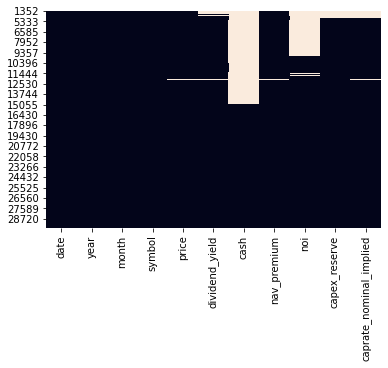

In [96]:
# Visualize where null values exist in our dataset
sns.heatmap(df_testing.isnull(), cbar=False)
plt.show()

Our dataset is pretty good, but cash and noi are two fields that have mor missing values. We will need to analyse to see why these are missing (panel nonresponse/time series gaps).

In [116]:
# Edits to dataframe for our analysis
df_office = df_testing.copy()
df_office = df_office.set_index('date')

# Transformations
df_office['price_pct'] = df_office.price.groupby(df_office['symbol']).pct_change()
df_office['cash_dif'] = df_office.cash.groupby(df_office['symbol']).diff()
df_office['noi_dif'] = df_office.noi.groupby(df_office['symbol']).diff()

df_office = df_office.loc[df_office['year'] >= 2012] #filter past 2012, to match sentiment data
df_office.head()

,year,month,symbol,price,dividend_yield,cash,nav_premium,noi,capex_reserve,caprate_nominal_implied,price_pct,cash_dif,noi_dif
date,,,,,,,,,,,,,
2012-01,2012,1,BXP,101.32,0.021713,1099783.0,0.066526,1.170438e+06,0.138359,0.049141,0.082826,0.0,-0.013053
2012-01,2012,1,CUZ,6.59,0.027314,5634.0,-0.287568,1.041740e+05,0.230453,0.082955,0.126496,0.0,0.000000
2012-01,2012,1,HIW,29.95,0.056761,34318.0,-0.018033,3.324460e+05,0.191745,0.076494,0.045375,0.0,0.000000
2012-01,2012,1,KRC,38.24,0.036611,78481.0,-0.055802,2.556130e+05,0.242399,0.060753,0.076880,0.0,0.000000
2012-01,2012,1,WRE,27.78,0.062455,40751.0,-0.111040,1.897160e+05,0.155351,0.066846,0.036567,0.0,0.000000


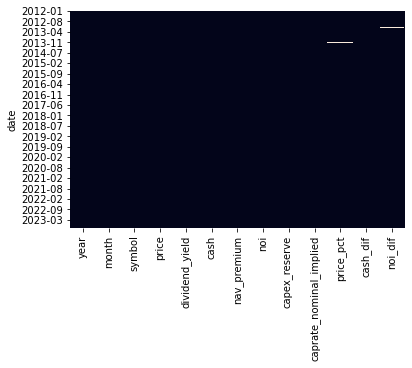

In [117]:
# View nulls
sns.heatmap(df_office.isnull(), cbar=False)
plt.show()

As we can see now, all of our null values were from earlier dates. With our filter after 2012 (to match our sentiment data) we have a complete dataset. 

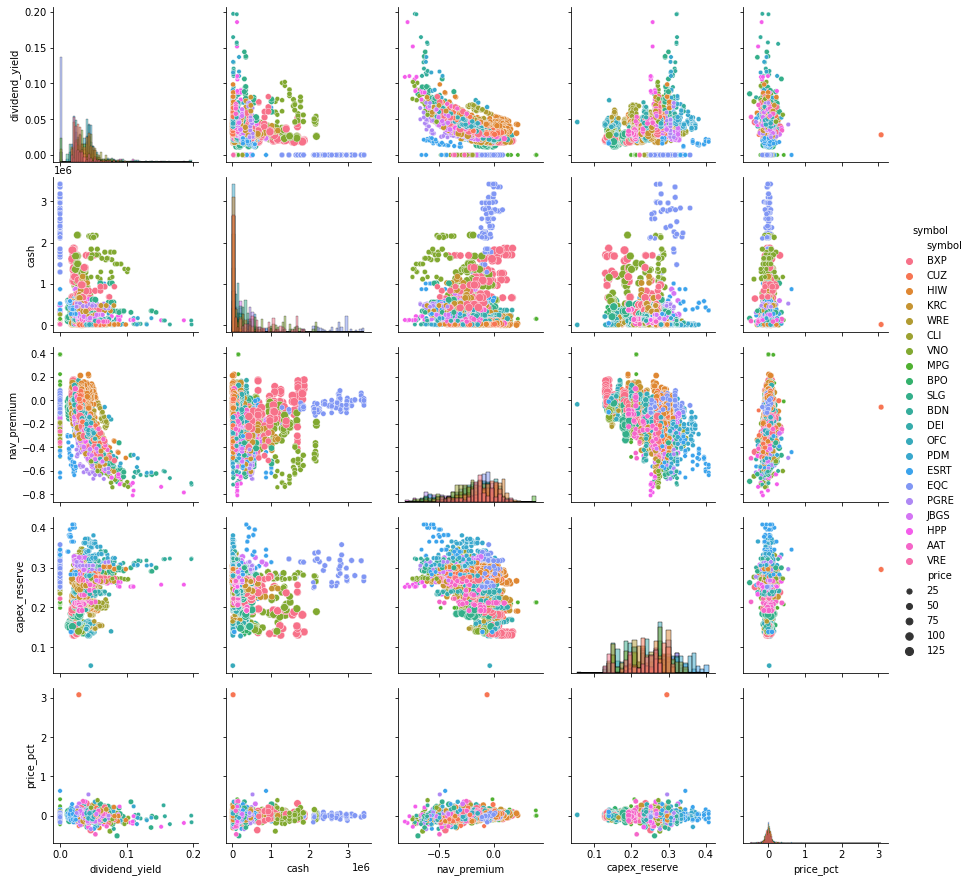

In [124]:
# Chart to analyze feature relationships
feature_list = ['symbol','dividend_yield','cash','nav_premium','capex_reserve','caprate_nominal','price_pct']
ax = sns.PairGrid(df_office.filter(items=feature_list), hue='symbol')
ax.map_diag(sns.histplot)
ax.map_offdiag(sns.scatterplot, size=df_office['price'])
ax.add_legend()

In [ ]:
# Select Features
feature = df_office.drop('price_pct', axis=1)

# Select Target
target = df_testing['price_pct']

# Set Training and Testing Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(feature , target, 
                                                    shuffle = True, 
                                                    test_size=0.2, 
                                                    random_state=0)

# Show the Training and Testing Data
print('Shape of training feature:', X_train.shape)
print('Shape of testing feature:', X_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of training label:', y_test.shape)